In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

# 데이터 확인

In [2]:
data = pd.read_csv('./data/SBUX.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       253 non-null    object 
 1   Open       253 non-null    float64
 2   High       253 non-null    float64
 3   Low        253 non-null    float64
 4   Close      253 non-null    float64
 5   Adj Close  253 non-null    float64
 6   Volume     253 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 14.0+ KB


In [3]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900
1,2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100
2,2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100
3,2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600
4,2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900


In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data['Volume'] = data['Volume'].astype(float)

data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.145752,4921900.0
2019-12-12,88.000000,88.889999,87.540001,88.209999,85.720032,10282100.0
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.167046,6714100.0
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.273941,6705600.0
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.642288,7296900.0


- scaling

In [7]:
X = data.drop('Volume', axis=1)
Y = data[['Volume']]

In [8]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
Y_ms = ms.fit_transform(Y)

train_x = X_ss[:200, :]
test_x = X_ss[200:, :]
train_y = Y_ms[:200, :]
test_y = Y_ms[200:, :]

train_x.shape, train_y.shape, test_x.shape, test_y.shape

((200, 5), (200, 1), (53, 5), (53, 1))

- preprocessing

In [11]:
train_tensor_x = Variable(torch.Tensor(train_x))
test_tensor_x = Variable(torch.Tensor(test_x))
train_tensor_y = Variable(torch.Tensor(train_y))
test_tensor_y = Variable(torch.Tensor(test_y))

train_x_f = torch.reshape(train_tensor_x, (train_tensor_x.shape[0], 1, train_tensor_x.shape[1]))
test_x_f = torch.reshape(test_tensor_x, (test_tensor_x.shape[0], 1, test_tensor_x.shape[1]))

train_x_f.shape, train_tensor_y.shape, test_x_f.shape, test_tensor_y.shape

(torch.Size([200, 1, 5]),
 torch.Size([200, 1]),
 torch.Size([53, 1, 5]),
 torch.Size([53, 1]))

# modeling

In [12]:
class GRU(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(GRU, self).__init__()

        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length =seq_length

        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        output, (hn) = self.gru(x, (h_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)

        return out

# train

In [19]:
num_epochs = 10000
lr = 0.0001
input_size = 5
hidden_size = 2
num_layers = 1
num_classes = 1

model = GRU(num_classes=num_classes, input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, seq_length=train_x_f.shape[1])
model

GRU(
  (gru): GRU(5, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [20]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [21]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [22]:
for epoch in range(num_epochs):
    outputs = model.forward(train_x_f)
    optimizer.zero_grad()
    loss = criterion(outputs, train_tensor_y)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch: {epoch}/{num_epochs} Loss : {loss.item()}')

Epoch: 0/10000 Loss : 0.23557478189468384
Epoch: 100/10000 Loss : 0.09250225126743317
Epoch: 200/10000 Loss : 0.047734297811985016
Epoch: 300/10000 Loss : 0.03902890160679817
Epoch: 400/10000 Loss : 0.03751537203788757
Epoch: 500/10000 Loss : 0.036522869020700455
Epoch: 600/10000 Loss : 0.035416003316640854
Epoch: 700/10000 Loss : 0.03422226384282112
Epoch: 800/10000 Loss : 0.03312848508358002
Epoch: 900/10000 Loss : 0.03215838596224785
Epoch: 1000/10000 Loss : 0.03130976855754852
Epoch: 1100/10000 Loss : 0.030466163530945778
Epoch: 1200/10000 Loss : 0.029540080577135086
Epoch: 1300/10000 Loss : 0.02846020646393299
Epoch: 1400/10000 Loss : 0.02728709764778614
Epoch: 1500/10000 Loss : 0.02600707858800888
Epoch: 1600/10000 Loss : 0.024691088125109673
Epoch: 1700/10000 Loss : 0.023339739069342613
Epoch: 1800/10000 Loss : 0.02193283475935459
Epoch: 1900/10000 Loss : 0.020478643476963043
Epoch: 2000/10000 Loss : 0.01902596652507782
Epoch: 2100/10000 Loss : 0.017619602382183075
Epoch: 2200/1

# test

In [23]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))

df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

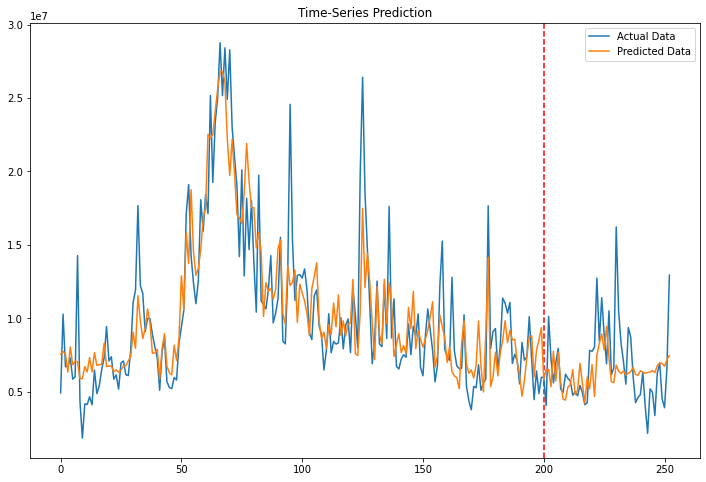

In [24]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

plt.figure(figsize=(12, 8))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()